# **Product Clustering with P2V and Agglomerative Clustering**

In [1]:
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse

In [31]:
DATA_PATH = '../data/'
EXPORT_PATH = '../export/'

In [4]:
baskets = pd.read_parquet(DATA_PATH + 'baskets.parquet')
baskets['basket'] = baskets.groupby(['week', 'shopper']).ngroup()

## **P2V DataLoader**

In [28]:
class P2VDataLoader:
    def __init__(
        self,
        baskets: pd.DataFrame,
        basket_var = 'basket',
        product_var = 'product'
    ):
        self.basket_var = basket_var
        self.product_var = product_var
        self.load(baskets)

    def basket_to_list(self, basket):
        return basket.astype(str).tolist()
    
    def baskets_to_list(self, baskets):
        baskets_grouped = baskets.groupby(self.basket_var)[self.product_var]
        baskets_list = baskets_grouped.agg(self.basket_to_list).tolist()
        return baskets_list
    
    # ToDo: move this functionality to helper class
    def load(self, baskets):
        try:
            with open(EXPORT_PATH + 'baskets_list', 'rb') as bl:
                print('Reading baskets_list from pickle...')
                self.output = pickle.load(bl)
        except IOError:
            print(f'No pickle found in {DATA_PATH}. Computing baskets_list. This can take 15 minutes...')
            self.output = self.baskets_to_list(baskets)
            with open(EXPORT_PATH + 'baskets_list', 'wb') as bl:
                pickle.dump(self.output, bl)
        finally:
              print("Successfully read baskets_list into memory.")

In [ ]:
#---------------------- Load data for P2V Model ----------------------#
p2v_data_loader = P2VDataLoader(baskets)
p2v_input = p2v_data_loader.output

## **P2V Model**

In [14]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

class P2V:
    def __init__(self, baskets, embedding_dimensions):
        w2v_config = {
            'sentences': baskets,
            'min_count': 2,
            'window': len(max(baskets, key=len)),
            'size': embedding_dimensions,
            'workers': 3,
            'sg': 1
        }
        self.init(w2v_config)

    def get_embeddings(self):
        return self.model.wv[self.model.wv.vocab]
             
    def most_similar_products(self, product):
        return self.model.wv.most_similar(product)
        
    def tsne_plot(self, n_components=2, perplexity=4, random_state=0, figsize=(15,15)):
        result = TSNE(
            n_components = n_components, 
            perplexity = perplexity, 
            random_state = random_state
        ).fit_transform(self.get_embeddings())
        plt.figure(figsize=figsize)
        plt.scatter(result[:, 0], result[:, 1])
        products = list(self.model.wv.vocab)
        for i, product in enumerate(products):
            plt.annotate(product, xy=(result[i, 0], result[i, 1]))
        plt.show()

    def init(self, w2v_config):
        try:
            self.model = Word2Vec.load("p2v.model")
        except IOError:
            self.model = Word2Vec(**w2v_config)
            self.model.save("p2v.model")

In [15]:
p2v_config = {
    'baskets': p2v_input,
    'embedding_dimensions': 100
}

p2v = P2V(**p2v_config)

In [18]:
p2v.most_similar_products('75')

[('74', 0.5859091877937317),
 ('76', 0.5728287696838379),
 ('78', 0.5715720653533936),
 ('79', 0.5675590634346008),
 ('77', 0.5590436458587646),
 ('72', 0.5488961935043335),
 ('73', 0.4891132414340973),
 ('71', 0.4239960014820099),
 ('239', 0.3955577611923218),
 ('70', 0.3585425615310669)]

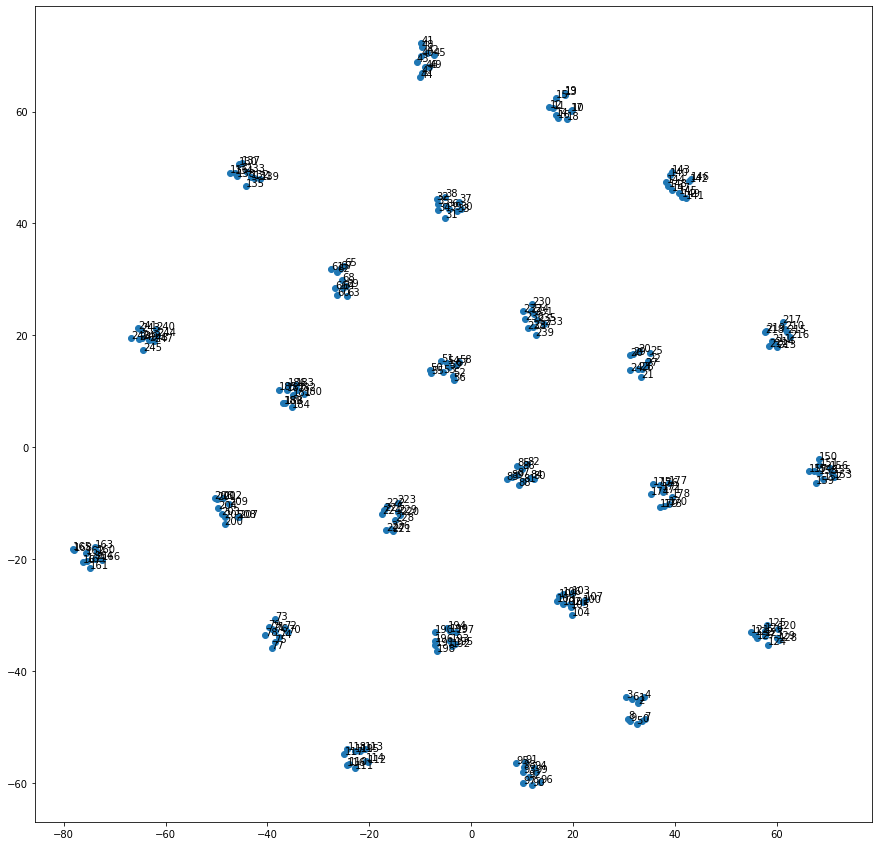

In [19]:
p2v.tsne_plot(figsize=(15,15))

## **Co-occurrence Printer**

In [47]:
class Co_occurence_printer:
    def __init__(self, data, group_var="basket", member_var="product"):
        self.data = data
        self.group_var = group_var
        self.member_var = member_var
        self.member_1 = member_var + '_1'
        self.member_2 = member_var + '_2'
        self.value = 'co-occurrence'
        self.table = self.compute_table()

    def co_occurrences_sparse(self):
        x = self.data
        group = self.group_var
        member = self.member_var
        
        row = x[group].values
        col = x[member].values
        dim = (x[group].max()+1, x[member].max()+1)

        group_member_table = scipy.sparse.csr_matrix(
            (np.ones(len(row), dtype=int), (row, col)),
            shape=dim
        )
        co_occurrences_sparse = group_member_table.T.dot(group_member_table).tocoo()
        co_occurrences_df = pd.DataFrame({
            self.member_1: co_occurrences_sparse.row,
            self.member_2: co_occurrences_sparse.col,
            self.value: co_occurrences_sparse.data,
        })
        return co_occurrences_df
        
    def compute_table(self):
        co_occurrences_df = self.co_occurrences_sparse()
        pivot_table = co_occurrences_df.pivot(
            index   = self.member_1, 
            columns = self.member_2, 
            values  = self.value
        ).fillna(0)
        return pivot_table

    def plot_heatmap(self, figsize=(10,10)):
        '''
            we clip the large self-co-occurences (diagonal values)
            to the max non-self coocuerence (non-diagonal value)

        '''
        table = self.table
        np.fill_diagonal(table.values, 0)
        max_non_diagonal = table.max().max()
        np.fill_diagonal(table.values, max_non_diagonal)
        dist_table = 1 - table
        # add figsize option
        plt.matshow(dist_table, cmap=plt.cm.Blues)
        plt.title(f"{self.member_var}-{self.value} heatmap")
        plt.xlabel(self.member_1)
        plt.ylabel(self.member_2)
        plt.show() 

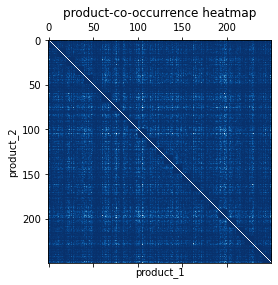

product_2,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
product_1,,,,,,,,,,,,,,,,,,,,,
0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4932.0,574.0,11041.0,2026.0,763.0,1362.0,4780.0,470.0,4828.0,18119.0
1,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16124.0,2228.0,12742.0,7224.0,6068.0,7541.0,12030.0,2107.0,30629.0,17982.0
2,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,946.0,2356.0,11997.0,950.0,999.0,4089.0,6190.0,2170.0,15655.0,4817.0
3,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1081.0,354.0,3406.0,1172.0,569.0,976.0,2155.0,250.0,3421.0,12281.0
4,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,...,3372.0,4143.0,5252.0,6948.0,3067.0,3387.0,4136.0,290.0,2862.0,23128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1362.0,7541.0,4089.0,976.0,3387.0,459.0,2909.0,3529.0,4082.0,4958.0,...,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0
246,4780.0,12030.0,6190.0,2155.0,4136.0,12211.0,4874.0,1002.0,4063.0,5273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0
247,470.0,2107.0,2170.0,250.0,290.0,929.0,1064.0,2680.0,2432.0,1487.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0


In [49]:
product_co_occurence = Co_occurence_printer(baskets)
product_co_occurence.plot_heatmap()
product_co_occurence.table

In [22]:
product_co_occurence.co_occurence_table


product_2,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
product_1,,,,,,,,,,,,,,,,,,,,,
0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4932.0,574.0,11041.0,2026.0,763.0,1362.0,4780.0,470.0,4828.0,18119.0
1,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16124.0,2228.0,12742.0,7224.0,6068.0,7541.0,12030.0,2107.0,30629.0,17982.0
2,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,946.0,2356.0,11997.0,950.0,999.0,4089.0,6190.0,2170.0,15655.0,4817.0
3,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1081.0,354.0,3406.0,1172.0,569.0,976.0,2155.0,250.0,3421.0,12281.0
4,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0,0.0,...,3372.0,4143.0,5252.0,6948.0,3067.0,3387.0,4136.0,290.0,2862.0,23128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1362.0,7541.0,4089.0,976.0,3387.0,459.0,2909.0,3529.0,4082.0,4958.0,...,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0,0.0
246,4780.0,12030.0,6190.0,2155.0,4136.0,12211.0,4874.0,1002.0,4063.0,5273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0,0.0
247,470.0,2107.0,2170.0,250.0,290.0,929.0,1064.0,2680.0,2432.0,1487.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189744.0,0.0,0.0


In [187]:
co_occurrences_df = co_occurrences_sparse(baskets)
co_occurrences_df = co_occurrences_df.sort_values(["product_1", "product_2"]).reset_index()
co_occurrences_df

co_occurrences_pivot = co_occurrences_df.pivot(
    index="product_1", 
    columns="product_2", 
    values="co-occurrence"
).fillna(0)

#pivot_df = pivot_df.fillna(0)
co_occurrences_pivot

product_2,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
product_1,,,,,,,,,,,,,,,,,,,,,
0,161640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4932.0,574.0,11041.0,2026.0,763.0,1362.0,4780.0,470.0,4828.0,18119.0
1,0.0,536705.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16124.0,2228.0,12742.0,7224.0,6068.0,7541.0,12030.0,2107.0,30629.0,17982.0
2,0.0,0.0,167169.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,946.0,2356.0,11997.0,950.0,999.0,4089.0,6190.0,2170.0,15655.0,4817.0
3,0.0,0.0,0.0,63468.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1081.0,354.0,3406.0,1172.0,569.0,976.0,2155.0,250.0,3421.0,12281.0
4,0.0,0.0,0.0,0.0,216964.0,0.0,0.0,0.0,0.0,0.0,...,3372.0,4143.0,5252.0,6948.0,3067.0,3387.0,4136.0,290.0,2862.0,23128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1362.0,7541.0,4089.0,976.0,3387.0,459.0,2909.0,3529.0,4082.0,4958.0,...,0.0,0.0,0.0,0.0,0.0,138586.0,0.0,0.0,0.0,0.0
246,4780.0,12030.0,6190.0,2155.0,4136.0,12211.0,4874.0,1002.0,4063.0,5273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,218078.0,0.0,0.0,0.0
247,470.0,2107.0,2170.0,250.0,290.0,929.0,1064.0,2680.0,2432.0,1487.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65194.0,0.0,0.0


In [ ]:
# plot co-occurence 
pivot_df_zeros = pivot_df.copy()
np.fill_diagonal(pivot_df_zeros.values, 0)
pivot_df_zeros_max = pivot_df_zeros.max().max()
np.fill_diagonal(pivot_df_zeros.values, pivot_df_zeros_max)
dist = 1 - pivot_df_zeros

plt.matshow(dist, cmap=plt.cm.Blues)
plt.title("Co-Clustering of Product Purchases")
plt.show()

### Create Product Clusters (categories)

In [ ]:
cut_bins = list(range(0, 251, 10))
cut_labels = list(range(0, 25))
baskets['product_cat'] = pd.cut(baskets['product'], bins=cut_bins, labels=cut_labels, right=False)

### Create Category Clusters (complementary categories like chips and coca-cola)

In [ ]:
cat_co_occurrences_df = co_occurrences_sparse(
    x=baskets,
    variable_basket="order_id",
    variable_product="product_cat"
)
cat_co_occurrences_df = cat_co_occurrences_df.sort_values(["product_1", "product_2"]).reset_index()
cat_co_occurrences_df = cat_co_occurrences_df.rename(columns={"product_1": "cat_1", "product_2": "cat_2"})
cat_pivot_df = cat_co_occurrences_df.pivot(
    index="cat_1", 
    columns="cat_2", 
    values="co-occurrence"
)
cat_pivot_df.head()

In [ ]:
plt.matshow(cat_pivot_df, cmap=plt.cm.Blues)
plt.title("Co-Clustering of Category Purchases")
plt.show()

In [ ]:
# rescale high diagonal values to mean
def rescale_diagonal(_df):
    df = _df.copy()
    np.fill_diagonal(df.values, 0)
    df_max = df.mean().mean()
    np.fill_diagonal(df.values, df_max)
    return df

cat_dist = rescale_diagonal(cat_pivot_df)

plt.matshow(cat_dist, cmap=plt.cm.Blues)
plt.title("Co-Clustering of Category Purchases")
plt.show()

In [ ]:
### Agglomerative Category Clustering

In [ ]:
df_agg = cat_dist.to_numpy()
# ward minimizes the variance of the clusters being merged
model = cluster.AgglomerativeClustering(linkage='ward', n_clusters=3).fit(df_agg)
new_order = np.argsort(model.labels_)
ordered_dist = df_agg[new_order] # can be your original matrix instead of dist[]
ordered_dist = ordered_dist[:,new_order]
plt.matshow(ordered_dist, cmap=plt.cm.Blues)

In [ ]:
cluster_labels = pd.DataFrame({"cluster": model.labels_})
baskets = baskets.merge(cluster_labels, left_on="product_cat", right_index=True)